# Decision Tree - Exploration 

In [1]:
import pandas as pd 
import numpy as np
path = '/home/antoni/Documents/Sample Data/Loan Data/Train_Loan.csv'
df1 = pd.read_csv(path)
print(df1.tail())
print(df1.columns)

      Loan_ID  Gender Married Dependents Education Self_Employed  \
609  LP002978  Female      No          0  Graduate            No   
610  LP002979    Male     Yes         3+  Graduate            No   
611  LP002983    Male     Yes          1  Graduate            No   
612  LP002984    Male     Yes          2  Graduate            No   
613  LP002990  Female      No          0  Graduate           Yes   

     ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
609             2900                0.0        71.0             360.0   
610             4106                0.0        40.0             180.0   
611             8072              240.0       253.0             360.0   
612             7583                0.0       187.0             360.0   
613             4583                0.0       133.0             360.0   

     Credit_History Property_Area Loan_Status  
609             1.0         Rural           Y  
610             1.0         Rural           Y  
611     

## Data Exploration and Clearing

In [2]:
df1.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [3]:
len(df1)

614

In [4]:
df1.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

Since we are simply looking to investigate decision trees let us simply remove the missing data.

UPDATE: We actually ran into a problem, I thought we could use categorical data directly with a decision tree, it turns out we cannot. I will think about how to deal with it.

In [5]:
df2 = df1.dropna()
df2 = df2.drop(columns = 'Loan_ID')

In [6]:
for i in df2.columns:
    if (df2[i].dtype == 'object') == True :
        print(i, df2[i].unique())

Gender ['Male' 'Female']
Married ['Yes' 'No']
Dependents ['1' '0' '2' '3+']
Education ['Graduate' 'Not Graduate']
Self_Employed ['No' 'Yes']
Property_Area ['Rural' 'Urban' 'Semiurban']
Loan_Status ['N' 'Y']


We will do some label encoding.

In [39]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
df2_enc = df2.copy()
for i in df2_enc.columns:
    if (df2_enc[i].dtype == 'object') == True :
        df2_enc[i +'_enc'] = enc.fit_transform(df2_enc[i])


for i in df2_enc.columns:
    e = list()
    if (df2_enc[i].dtype == 'object') == True :
        del df2_enc[i]

print(df2_enc.head())

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   
5             5417             4196.0       267.0             360.0   

   Credit_History  Gender_enc  Married_enc  Dependents_enc  Education_enc  \
1             1.0           1            1               1              0   
2             1.0           1            1               0              0   
3             1.0           1            1               0              1   
4             1.0           1            0               0              0   
5             1.0           1            1               2              0   

   Self_Employed_enc  Property_Area_enc  Loan_Status_enc  
1                  0                  0            

In [8]:
from sklearn.model_selection import train_test_split
X = df2_enc.drop(columns = 'Loan_Status_enc')
y = df2_enc['Loan_Status_enc']
TX, VX, Ty, Vy = train_test_split(X, y, random_state =0)

In [9]:
from sklearn.tree import DecisionTreeClassifier
dtc1 = DecisionTreeClassifier(random_state = 0)
dtc1.fit(TX,Ty)
pred1 = dtc1.predict(VX)

In [10]:
from sklearn.metrics import mean_absolute_error
def get_me(dtc):
    dtc.fit(TX, Ty)
    pred = dtc.predict(VX)
    return mean_absolute_error(Vy, pred)
def get_me_mean(dtc):
    z=list()
    for i in range(50):
        z.append(get_me(dtc))
    return(sum(z)/50)

In [11]:
print(get_me_mean(dtc1))

0.375


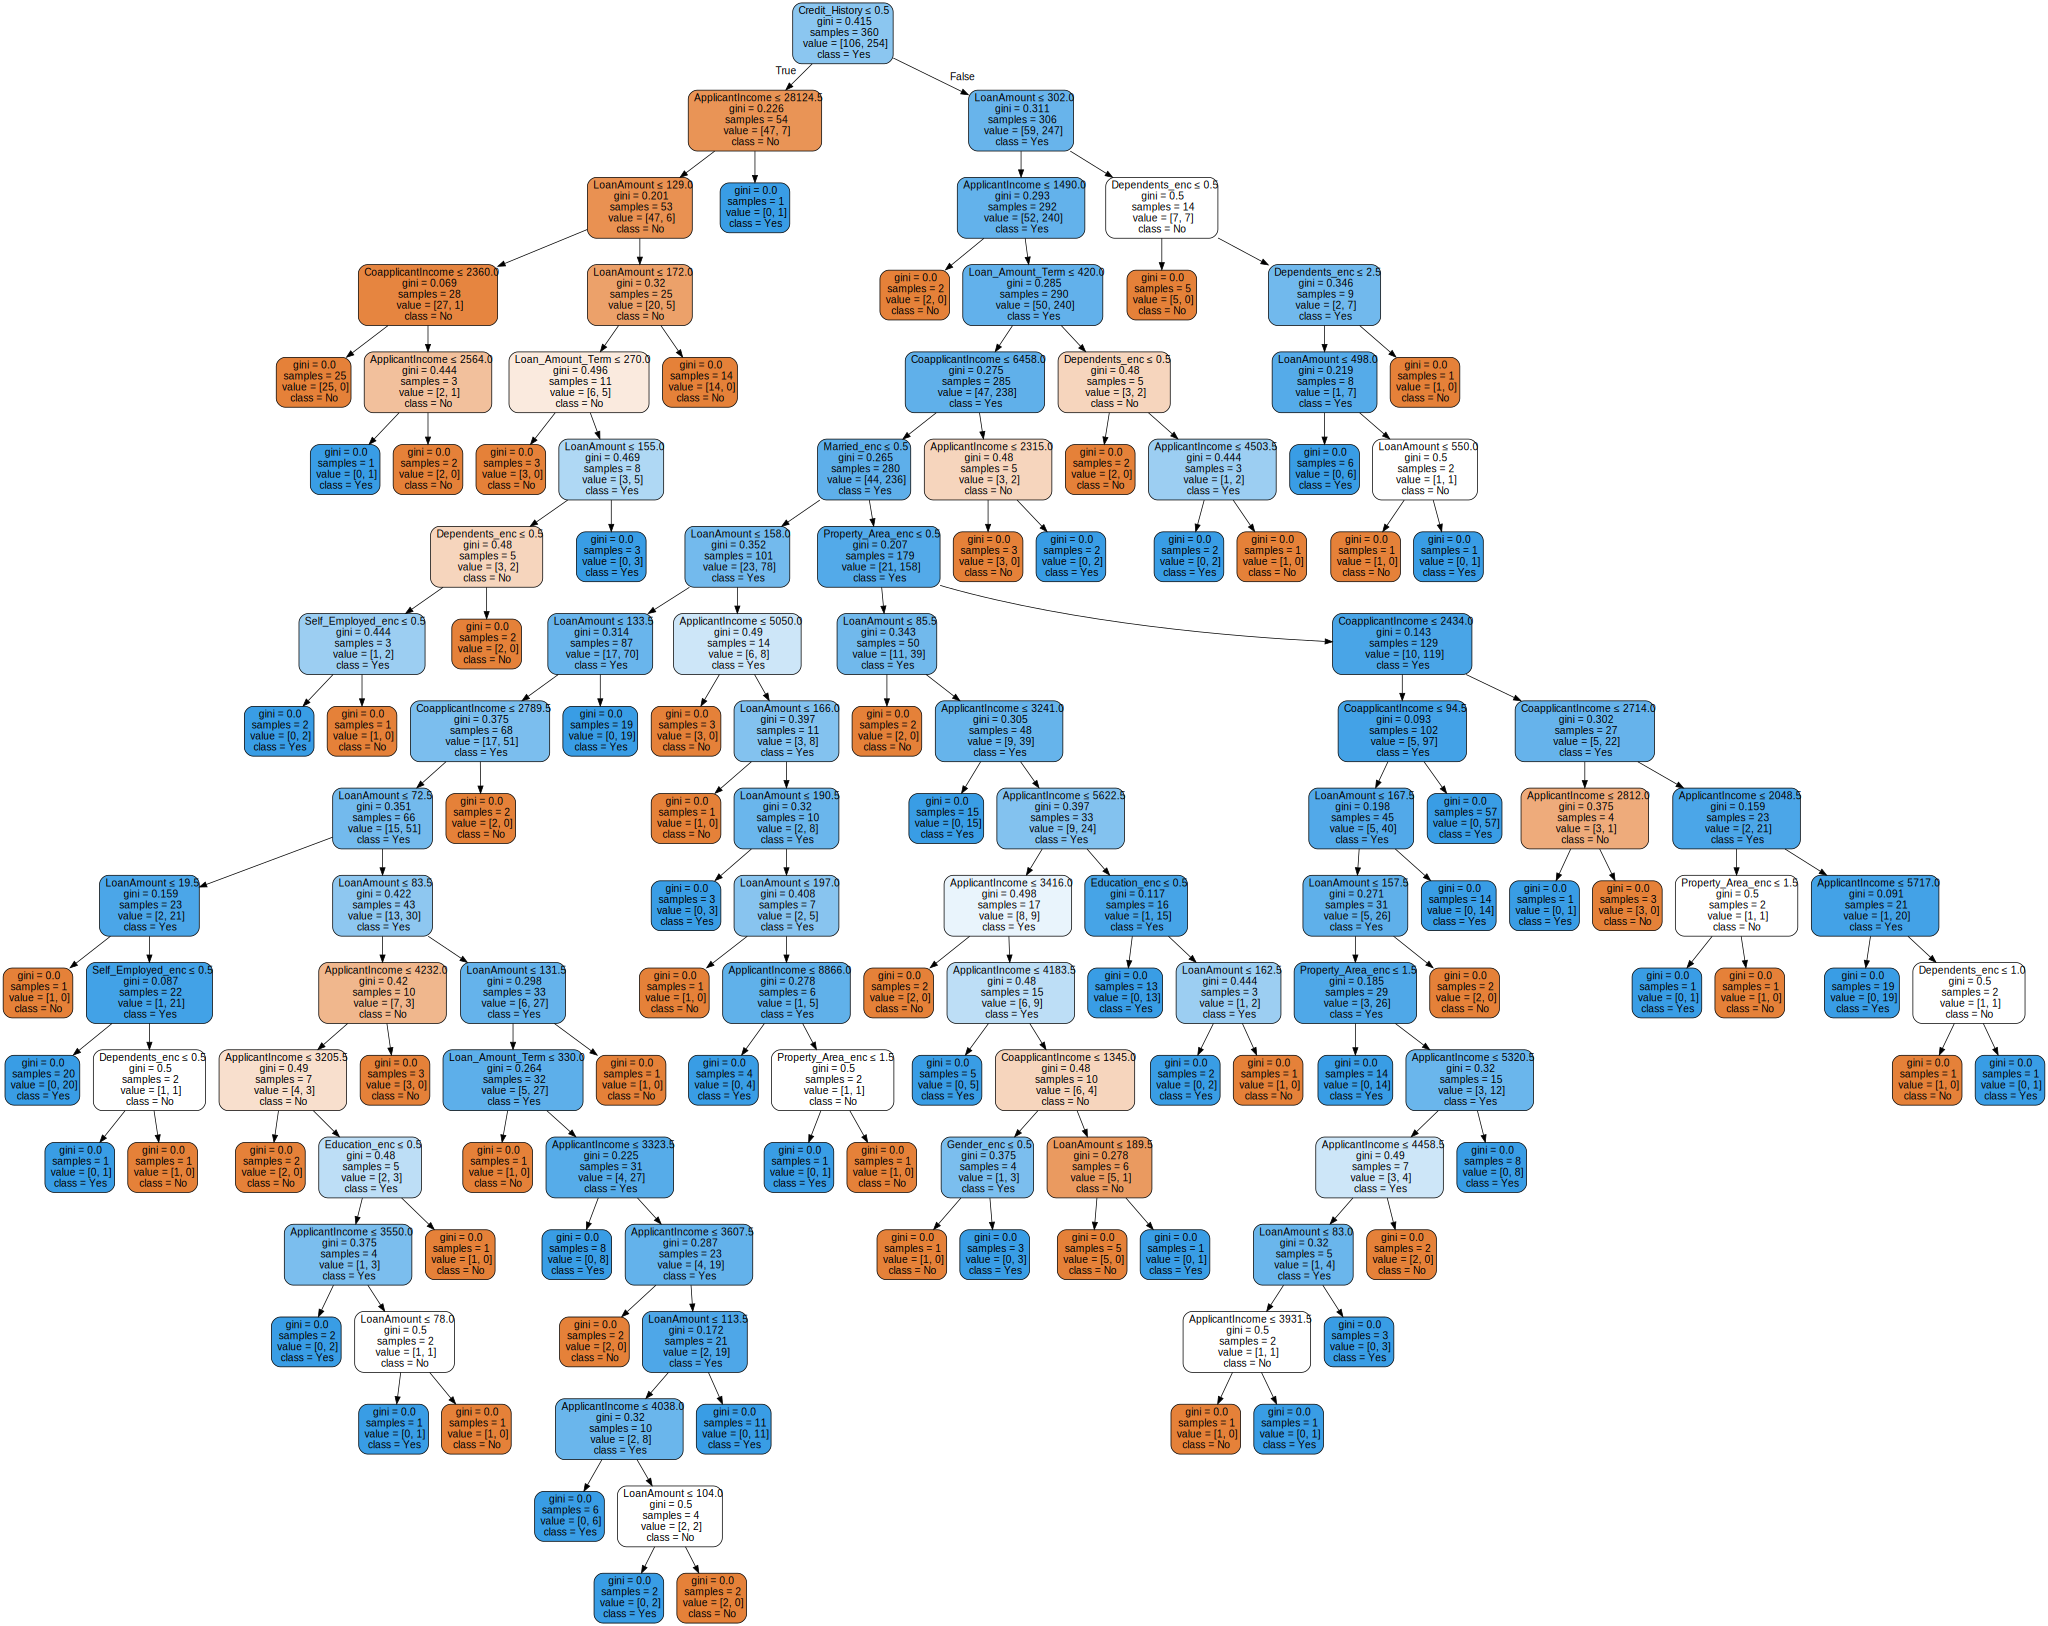

In [12]:
from sklearn.tree import export_graphviz
import graphviz
dot_data = export_graphviz(dtc1, out_file=None, feature_names=X.columns, class_names = ['No', 'Yes'],
                         filled=True, rounded=True,  
                         special_characters=True,)
graphviz.Source(dot_data)


## Altering the min_samples_split parameter

In [13]:
dtc2 = DecisionTreeClassifier(min_samples_split=100)
dtc2.fit(TX,Ty)
print(get_me_mean(dtc2))

0.22933333333333306


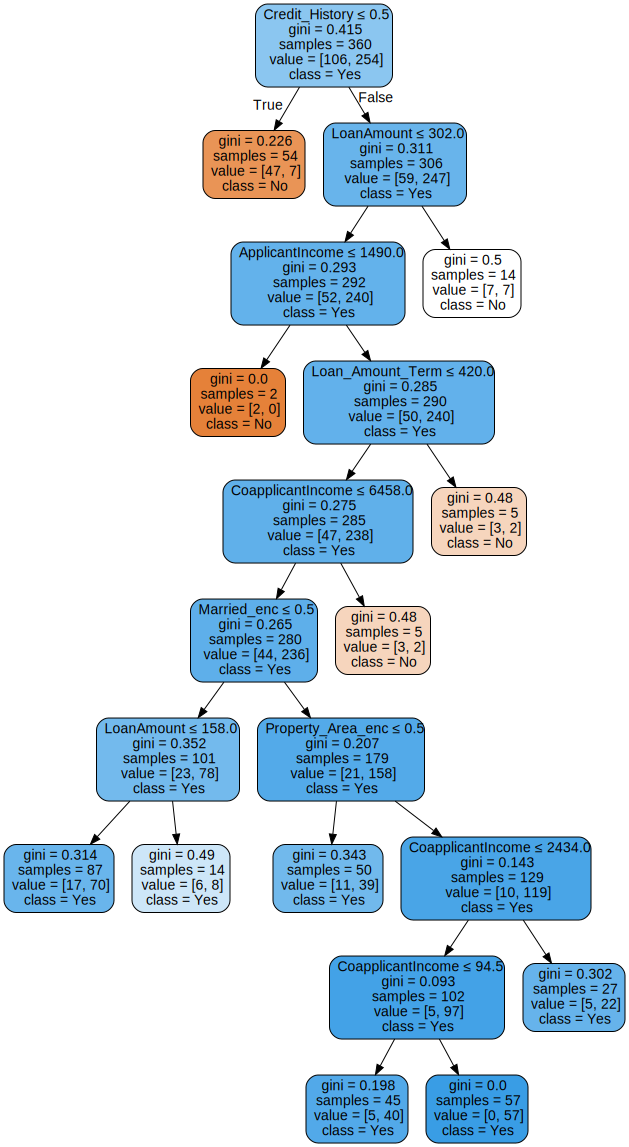

In [14]:
dot_data = export_graphviz(dtc2, out_file=None, feature_names=X.columns, class_names = ['No', 'Yes'],
                         filled=True, rounded=True,  
                         special_characters=True,)
graphviz.Source(dot_data)

### Trying to find the optimal value for min_sample_split
Also obviously this is will be only the optimal value if we keep all the other parameters the same. But let us see keeping the the other parameters default which would be the optimal value.

In [15]:
l = []
for i in range(2,100):
    dtc = DecisionTreeClassifier(min_samples_split=i)
    a = get_me_mean(dtc)
    l.append((a, i))

In [16]:
print(min(l))

(0.22799999999999976, 90)


## Altering the max_depth parameter


In [17]:
min

0.2825


In [18]:
l = []
for i in range(2,100):
    dtc = DecisionTreeClassifier(max_depth=i)
    a = get_me_mean(dtc)
    l.append((a, i))

In [19]:
print(min(l))

(0.22916666666666646, 2)


In [76]:
import pandas as pd
lst_errors = [err[0] for err in l]
df = pd.DataFrame({'depth': list(range(2, 100)), 'mse': lst_errors})
df.head()

,depth,mse
0,2,0.316667
1,3,0.321167
2,4,0.325000
3,5,0.450000
4,6,0.383333


In [78]:
min(lst_errors)

0.3166666666666665

In [79]:
lst_errors

[0.3166666666666665,
 0.3211666666666664,
 0.32499999999999973,
 0.44999999999999957,
 0.38333333333333314,
 0.39999999999999986,
 0.3825,
 0.42483333333333356,
 0.43149999999999994,
 0.4496666666666665,
 0.4464999999999998,
 0.44433333333333325,
 0.4508333333333331,
 0.4563333333333332,
 0.4543333333333331,
 0.45749999999999985,
 0.4583333333333331,
 0.46033333333333315,
 0.4603333333333331,
 0.4598333333333332,
 0.4581666666666667,
 0.4574999999999998,
 0.4606666666666667,
 0.4559999999999998,
 0.46083333333333326,
 0.45783333333333315,
 0.4613333333333332,
 0.46066666666666656,
 0.45966666666666645,
 0.45733333333333315,
 0.46233333333333326,
 0.4628333333333331,
 0.4583333333333331,
 0.45916666666666633,
 0.45849999999999985,
 0.4598333333333333,
 0.4548333333333332,
 0.4631666666666665,
 0.46216666666666656,
 0.4583333333333332,
 0.46283333333333315,
 0.4561666666666666,
 0.4586666666666667,
 0.45916666666666667,
 0.4568333333333331,
 0.4584999999999998,
 0.4611666666666665,
 0.45

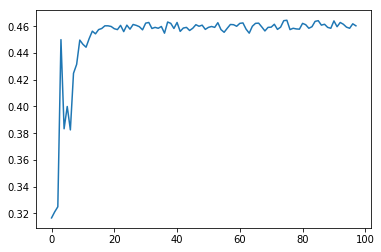

In [77]:
df['mse'].plot()

This is an unexpected result because a max_depth of 2 seems to create least error. We definitley shouldn't expect this because that means it can only account for a two features. Lets see the visualisation for this.

0.22999999999999982


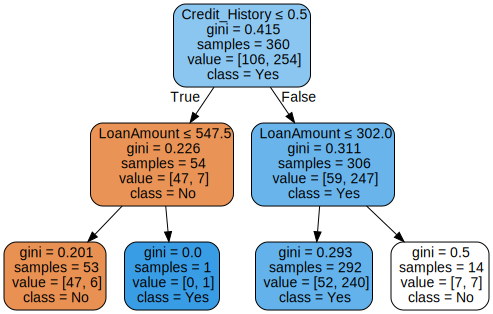

In [20]:
dtc = DecisionTreeClassifier(max_depth=2)
dtc.fit(TX,Ty)
print(get_me_mean(dtc))
dot_data = export_graphviz(dtc, out_file=None, feature_names=X.columns, class_names = ['No', 'Yes'],
                         filled=True, rounded=True,  
                         special_characters=True,)
graphviz.Source(dot_data)

## Altering the max_feature parameter

In [21]:
dtc = DecisionTreeClassifier(max_features='auto')
dtc.fit(TX,Ty)
print(get_me_mean(dtc))

0.31250000000000006


In [25]:
TX.columns.nunique()

11

In [30]:
l = []
for i in range(1,12):
    dtc = DecisionTreeClassifier(max_features=i)
    a = get_me_mean(dtc)
    l.append((a, i))

In [32]:
print(min(l))

(0.3076666666666667, 4)


0.3006666666666668


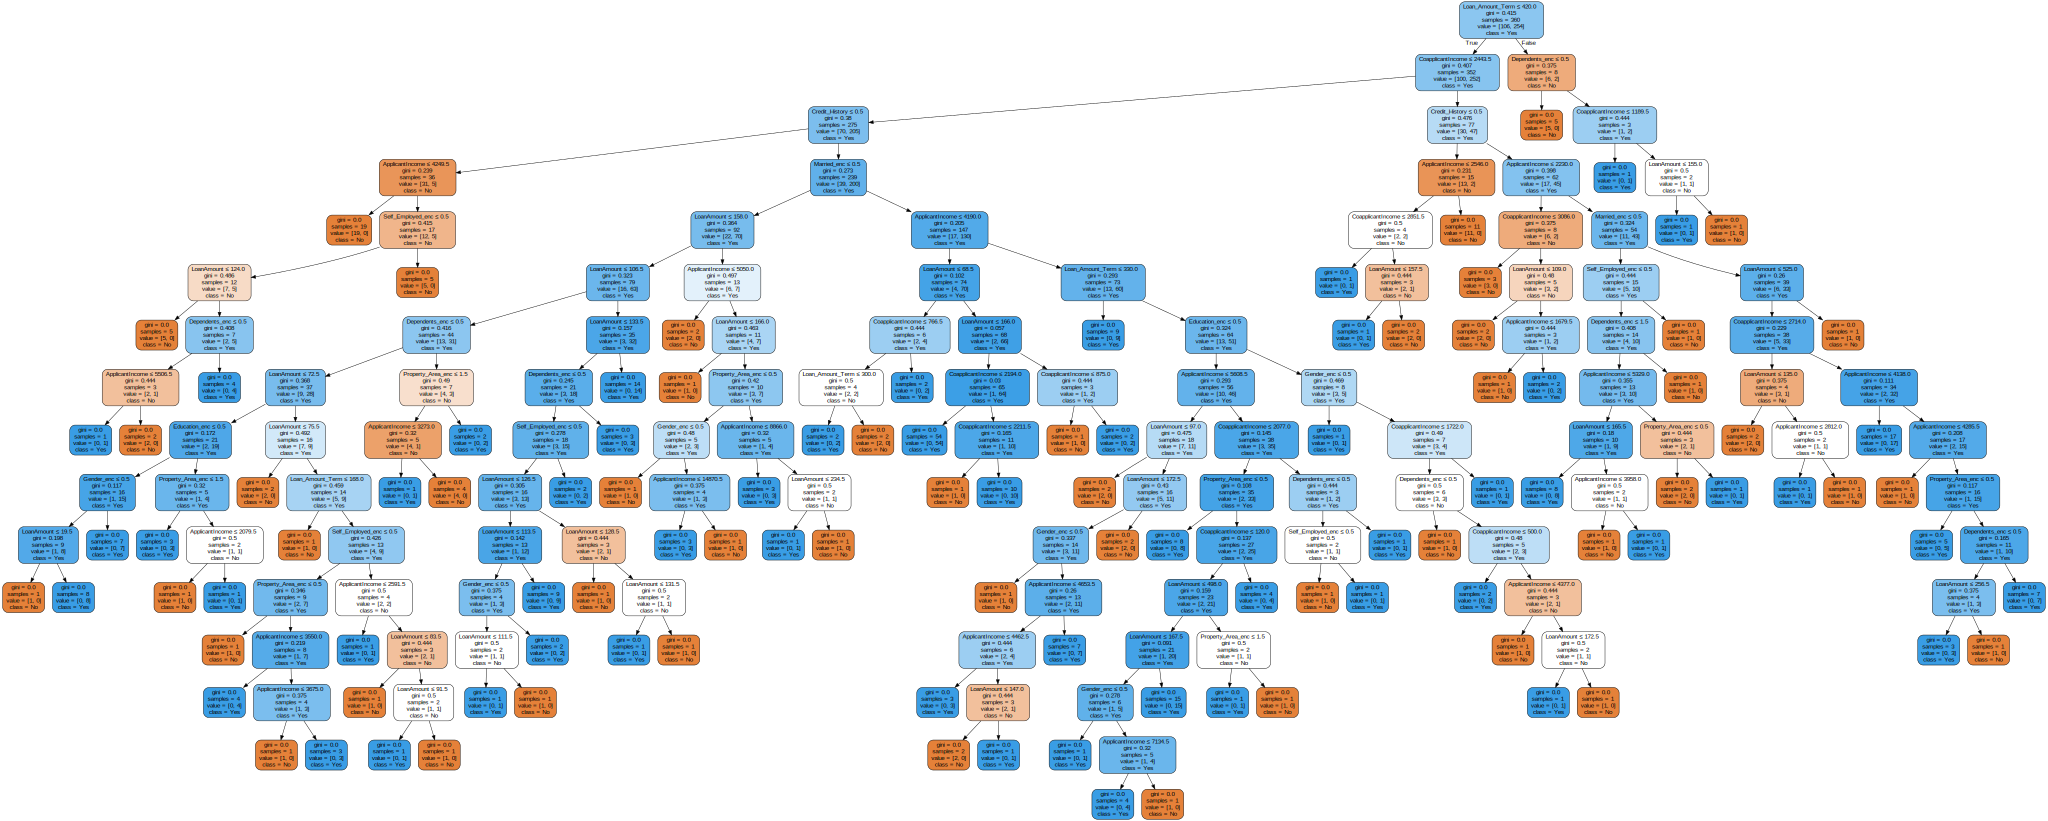

In [35]:
dtc = DecisionTreeClassifier(max_features=4)
dtc.fit(TX,Ty)
print(get_me_mean(dtc))
dot_data = export_graphviz(dtc, out_file=None, feature_names=X.columns, class_names = ['No', 'Yes'],
                         filled=True, rounded=True,  
                         special_characters=True,)
graphviz.Source(dot_data)

## Overview
We have the strange result that setting the max_depth to 2 gives us the lowest MAE. We also saw that setting the min_sample_split parameter to 90 also gives us a comparable MAE. It seems to me however that the former case will surely not give us strong results on unseen data, while the latter case seems like it might peform alright. I will test this hypothes on the test data.

In [49]:

df_test = pd.read_csv(path)
df_test = df_test.dropna()
df_test = df_test.drop(columns = 'Loan_ID')
enc1 = LabelEncoder()

for i in df_test.columns:
    if (df_test[i].dtype == 'object') == True :
        df_test[i +'_enc'] = enc1.fit_transform(df_test[i])


for i in df_test.columns:
    e = list()
    if (df_test[i].dtype == 'object') == True :
        del df_test[i]




In [50]:
print(df_test.head())

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   
5             5417             4196.0       267.0             360.0   

   Credit_History  Gender_enc  Married_enc  Dependents_enc  Education_enc  \
1             1.0           1            1               1              0   
2             1.0           1            1               0              0   
3             1.0           1            1               0              1   
4             1.0           1            0               0              0   
5             1.0           1            1               2              0   

   Self_Employed_enc  Property_Area_enc  Loan_Status_enc  
1                  0                  0            

In [51]:
X = df_test.drop(columns = 'Loan_Status_enc')
y = df_test['Loan_Status_enc']
TX, VX, Ty, Vy = train_test_split(X, y)

In [56]:
import seaborn as sns

In [65]:
df3 = df_test[['LoanAmount', 'Loan_Status_enc']]

AttributeError: module 'seaborn' has no attribute 'plot'

(0.3166666666666665, 2)
